# Vehicle Detection Project -P5

The goals / steps of this project are the following:
* Demonstrate the benefits of Histogram of color as a feature in vehicle detection.
* Demonstrate the benefits of Spacial Bins as a feature in vehicle detection.
* Demonstrate the benefits of HOG-Histogram of Oriented Gradients as a feature in vehicle detection.
* Visualize the benifits of normalization
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected. Soure(2)

## Intorduction

In order to be able to detect a vehicle near a car each image form a forward facing camera is scanned with a sliding window to identify windows with car or not-car images. Techniques are used to evaluate the window images. These techniques were HOG-Histogram of Oriented Gradients,  Spatial Bins and Histogram of color. Many color spaces were tested.

Note: A modified version of these functions were used to visualize the benefits each of these techniques. The modification enable visualizing any combination of the 3 channels of the color space. These modified functions are in the mod_functions.py folder.

The predictive classifier below used functions to process all 3 channels in the attempt to capture as much information as possible. These are the  functions listed in the 'Building the Classifier' section below.

[Link to Final Output Video]([video link](https://youtu.be/IdA85pDjplU)

In [1]:
#Libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import glob
from skimage.feature import hog
from skimage import color, exposure
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from mod_functions import *

#%matplotlib qt
%matplotlib inline

/Users/williamkapsalis/anaconda/envs/python3Environment/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/williamkapsalis/anaconda/envs/python3Environment/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Analysis of the Data and Methods


### import data

In [2]:
## Divide up into cars and notcars
#images are divided up into vehicles and non-vehicles
#I put folder 'vehicles_smallest' and 'non-vehicles_smallest'in a folder 'imgs'
#cars = glob.glob('vehicles/*/*.png')                   #for accurate runs
cars = glob.glob('vehicles_smallset/*/*.jpeg')          # for quick testing
print(type(cars), 'type cars')
print(len(cars), 'cars')
#notcars = glob.glob('non-vehicles/*/*.png')            #for accurate runs
notcars = glob.glob('non-vehicles_smallset/*/*.jpeg')   # for quick testing
print(len(notcars), 'notcars')

<class 'list'> type cars
1196 cars
1199 notcars


### Example car and not-car

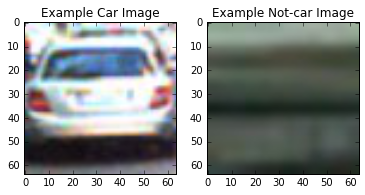

In [3]:
# images are divided up into vehicles and non-vehicles
data_info = data_look(cars, notcars)
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

## Spacial Binned Color Features

Image pixels were broken down to spacial bins. The image was resized and flattened. The visualization below shows the  difference in spacial bins for the car and not-car samples. 

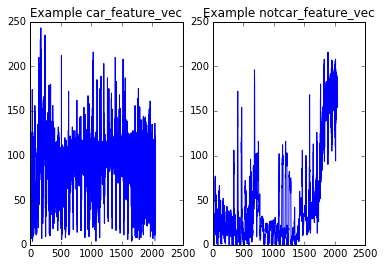

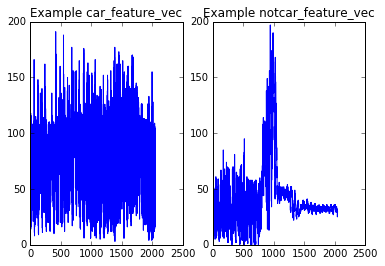

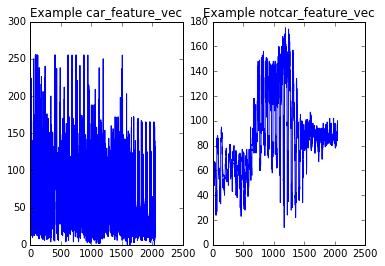

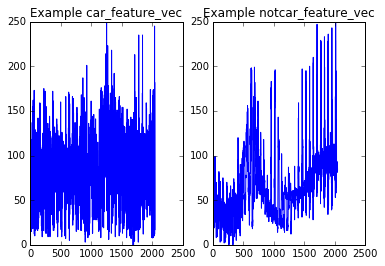

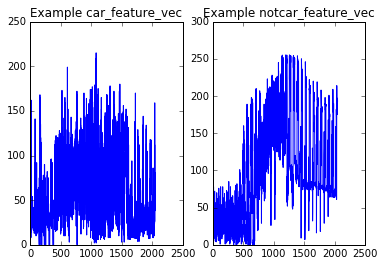

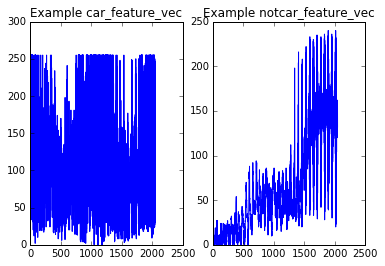

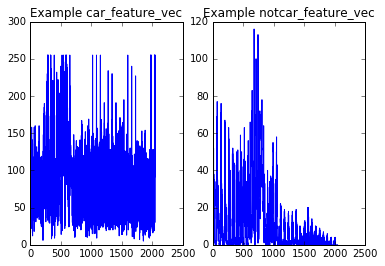

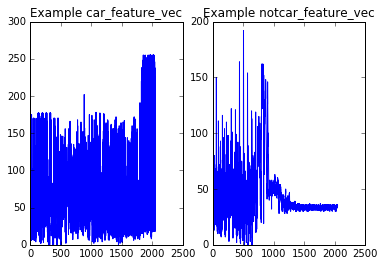

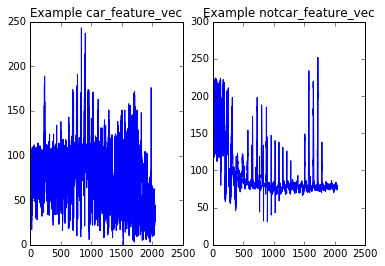

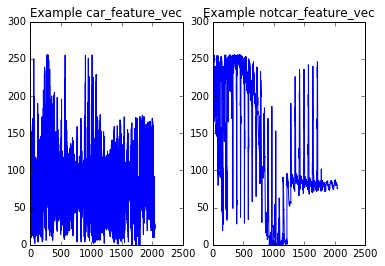

In [4]:
from mod_functions import * #form mof_functions.py

car_inds = np.random.randint(0, len(cars),10)

for car_ind in car_inds:
    car_image = mpimg.imread(cars[car_ind])
    car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2HLS)#HLS!!!
    car_feature_vec = bin_spatial(car_image, size=(32, 32), channel_1 = True, channel_2 = False, channel_3 = True)

    notcar_image = mpimg.imread(notcars[car_ind])
    notcar_feature_vec = bin_spatial(notcar_image, size=(32, 32), channel_1 = True, channel_2 = False, channel_3 = True)
    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.plot(car_feature_vec)
    plt.title('Example car_feature_vec')
    plt.subplot(122)
    plt.plot(notcar_feature_vec)
    plt.title('Example notcar_feature_vec')

Above you can see a difference in the spacial bin pattern between car and non-car. These differences can be used as a feature in predicting car vs non-car in a sliding window on an image.

## Color Histogram 
Histograms of the channels of an image. Each channel value is put in one of 32 bin, one set of bins for each channel of the color space. Below shows the 3 histograms. Below the data pattern of the 3 histograms for cars and the 3 histograms for non-car shows a difference between car and not-car. Again, these can be used as features in predicting if a sliding window across and image is car or not-car.

In [5]:
from mod_functions import * #form mof_functions.py

def plot_three_bar_charts_car_notcar(car_rh, car_gh, car_bh, notcar_rh, notcar_gh, notcar_bh, bincen, color_space = 'RGB'):
                     
    cs_list = list(color_space)
    if car_rh is not None:
        fig = plt.figure(figsize=(18,3))
        plt.subplot(161)
        plt.bar(bincen, car_rh[0])
        plt.xlim(0, 256)
        plt.title('Car ' + cs_list[0] + ' Histogram')
        plt.subplot(162)
        plt.bar(bincen, car_gh[0])
        plt.xlim(0, 256)
        plt.title('Car ' + cs_list[1] + ' Histogram')
        plt.subplot(163)
        plt.bar(bincen, car_bh[0])
        plt.xlim(0, 256)
        plt.title('Car ' + cs_list[2] + ' Histogram') 
        
        plt.subplot(164)
        plt.bar(bincen, notcar_rh[0])
        plt.xlim(0, 256)
        plt.title('NotCar ' + cs_list[0] + ' Histogram')
        plt.subplot(165)
        plt.bar(bincen, notcar_gh[0])
        plt.xlim(0, 256)
        plt.title('NotCar ' + cs_list[1] + ' Histogram')
        plt.subplot(166)
        plt.bar(bincen, notcar_bh[0])
        plt.xlim(0, 256)
        plt.title('NotCar ' + cs_list[2] + ' Histogram')          
        
        fig.tight_layout()
    else:
        print('Your function is returning None for at least one variable...')   

64


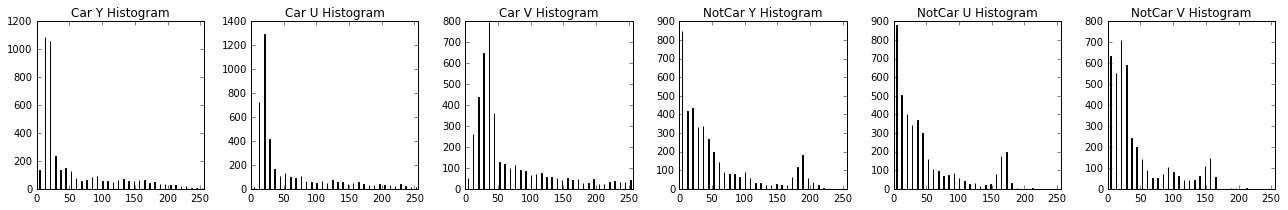

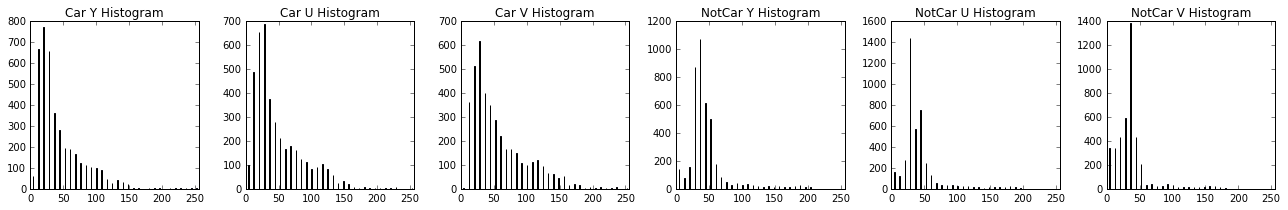

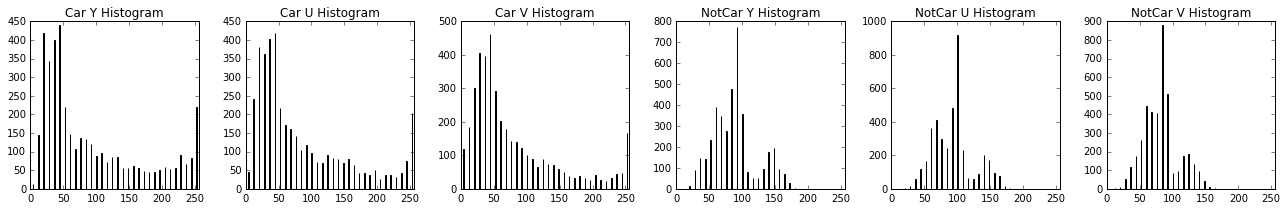

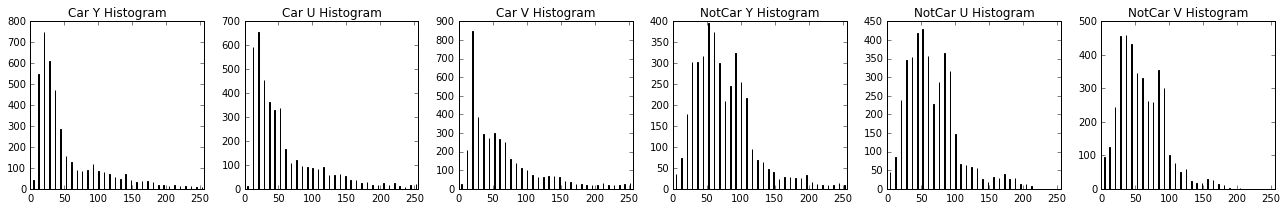

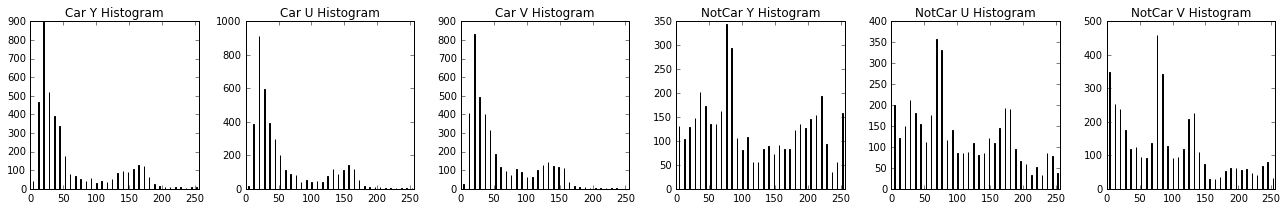

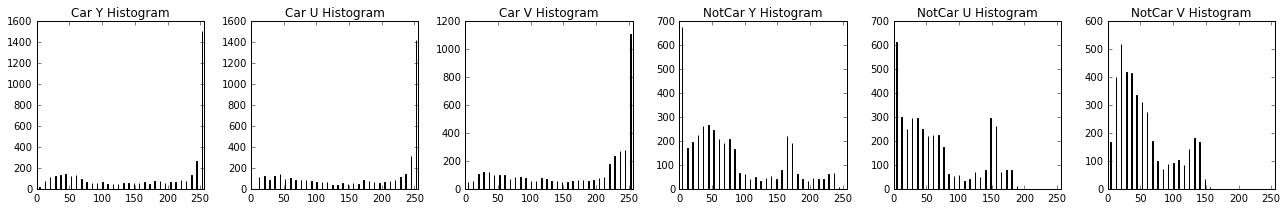

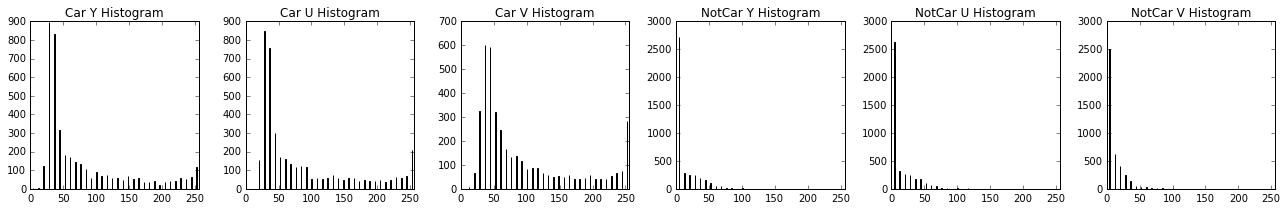

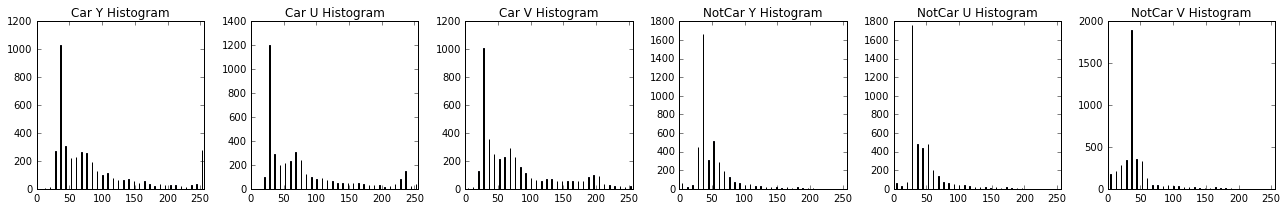

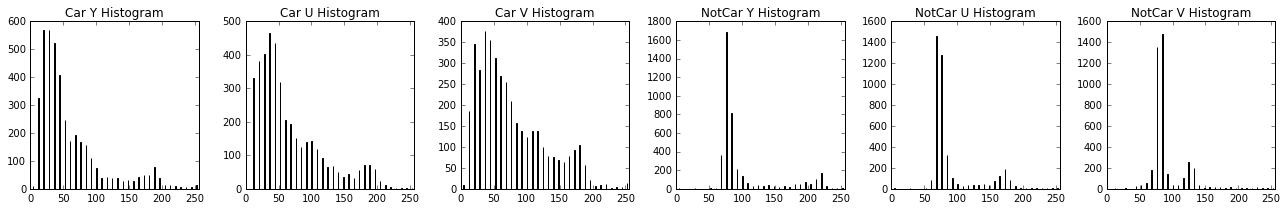

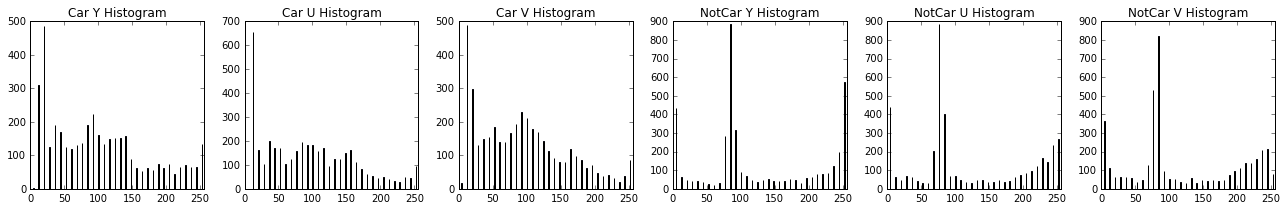

In [6]:
from mod_functions import * #form mof_functions.py

for car_ind in car_inds:
    car_image = mpimg.imread(cars[car_ind])
    car_rh, car_gh, car_bh, bincen, feature_vec =  color_hist(car_image, nbins=32, bins_range=(0, 256), channel_1 = False, channel_2 = True, channel_3 = True)

    notcar_image = mpimg.imread(notcars[car_ind])
    notcar_rh, notcar_gh, notcar_bh, bincen, feature_vec = color_hist(notcar_image, nbins=32, bins_range=(0, 256), channel_1 = False, channel_2 = True, channel_3 = True)

    plot_three_bar_charts_car_notcar(car_rh=car_rh, car_gh=car_gh, car_bh=car_bh, notcar_rh=notcar_rh, notcar_gh=notcar_gh, notcar_bh=notcar_bh, bincen=bincen, color_space = 'YUV')

print(len(feature_vec))


Above shows the color Histograms of car and not car for 10 examples of each. You can see cars, in general have higher values to the left of the histograms and it slops down to the right. Again, these differences can be used as a feature in predicting car vs non-car in a sliding window on an image.

# HOG- Histogram of Oriented Gradients

HOG consists of:
- (optional) global image normalization
- computing the gradient image in x and y
- computing gradient histograms
- normalizing  across blocks
- flattening into a feature vector
source(1)

Below shows the HOG image for 10 car window(left) and 10 not-car(right) window examples.

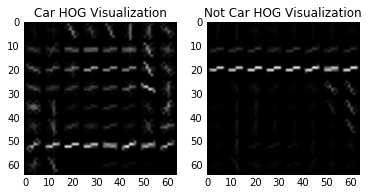

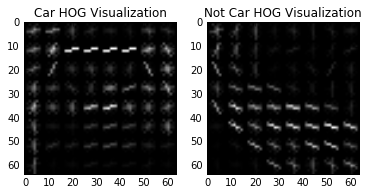

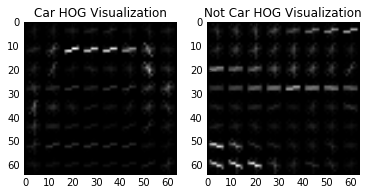

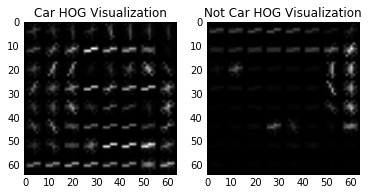

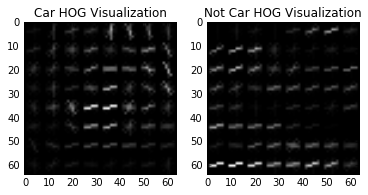

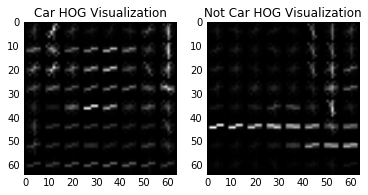

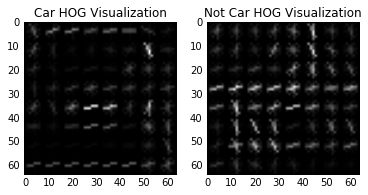

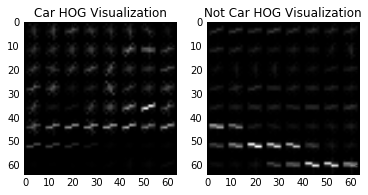

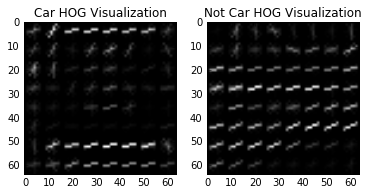

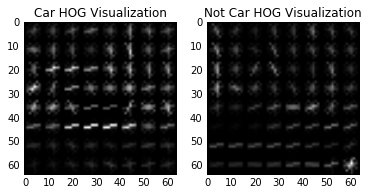

In [7]:
car_inds = np.random.randint(0, len(cars),10)
orient = 9
pix_per_cell = 8
cell_per_block = 2

for car_ind in car_inds:
    car_image = mpimg.imread(cars[car_ind])
    car_feature_vec = bin_spatial(car_image, size=(32, 32), channel_1 = True, channel_2 = True, channel_3 = True)
    car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
    car_features, car_hog_image = get_hog_features(car_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

    notcar_image = mpimg.imread(notcars[car_ind])
    notcar_feature_vec = bin_spatial(notcar_image, size=(32, 32), channel_1 = True, channel_2 = True, channel_3 = True)
    notcar_gray = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)
    notcar_features, notcar_hog_image = get_hog_features(notcar_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_hog_image, cmap='gray')
    plt.title('Car HOG Visualization') 
    plt.subplot(122)
    plt.imshow(notcar_hog_image, cmap='gray')
    plt.title('Not Car HOG Visualization') 

Above demonstrates the HOG difference between car windows and not-car windows. You can almost see the out line of the cars in the car windows. Again, these differences can be used as a feature in predicting car vs non-car in a sliding window on an image.

## Extract Features Function and Benefits of Normalization

The extract features function below gets all the information from the HOG, Spacial Bin and Color Histogram method mentioned above. 

The below example shows the benefit of normalizing the data.

<class 'list'> type cars
1196 cars
1199 notcars
4793


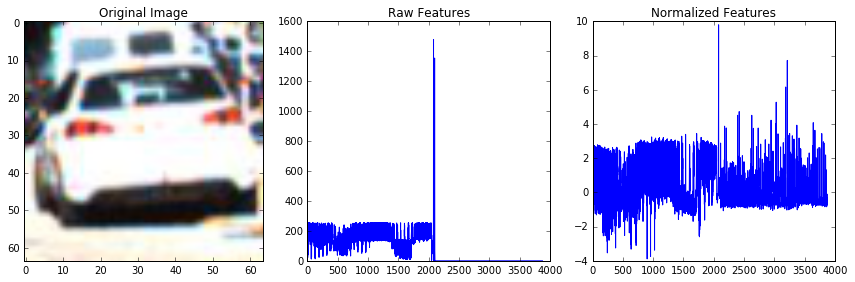

In [8]:

#cars = glob.glob('vehicles/*/*.png')                   #for accurate runs
cars = glob.glob('vehicles_smallset/*/*.jpeg')          # for quick testing
print(type(cars), 'type cars')
print(len(cars), 'cars')
#notcars = glob.glob('non-vehicles/*/*.png')            #for accurate runs
notcars = glob.glob('non-vehicles_smallset/*/*.jpeg')   # for quick testing
print(len(notcars), 'notcars')

notcars = np.concatenate([notcars, notcars, notcars])
car_features = extract_features(cars, cspace='LUV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), hog_channel=0, chan_1 = True, chan_2 = False, chan_3 = True)
notcar_features = extract_features(notcars, cspace='LUV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), hog_channel=0, chan_1 = True, chan_2 = False, chan_3 = True)

if len(car_features) > 0:
    # Create an array stack of feature vectors
    #print(car_features, 'and', notcar_features)
    X = np.vstack((car_features, notcar_features)).astype(np.float64)  
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    #print(X_scaler)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    print(len(scaled_X))
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

Above show the benifit of normalixzing data. The first 2 channels of the image are visulalized with and without normalization. Note the second channel is barely visible in the raw/non-normalized data but with noramlixzation it is more representation of the realtionship and variation in both channesl.

## Classifier Functions and Methods

The classifier below uses HOG, spatial bins and color histogram method to get features to use to predict which of the sliding windows contained a car image and which did not. Multiple color spaces were evaluated and YCrCb was used because it showed good differenciate between car and not-car with the visualization methods above and had good preliminary results with my first version of the classifier algorithm. 


#### Histogram of Oriented Gradients (HOG)
Many HOG variables were tested with the following settings giving fewer false positives. 
set_orient = 9
set_pix_per_cell = 4                    
set_cell_per_block = 4
I thought fewer set_pix_per_cell would improve the resolution of the HOG image. This did reduce false positives but did increase run time.

Spatial binning dimensions were increased to (64, 64) and the number of histogram bins was also increased to 64.
I thought the increase would increase the differentiation between car an not-car. It did improve the results but also increased the run time.

These are in the cell 'Classifier and Settings' and starts with '*****HERE*****'.


#### Classifier 
The features were scaled and ran in a linearSVC classifier. I included a C=0.001. This decrease the number of false positives.
The classifier code is also in the cell 'Classifier and Settings' below.


#### Sliding Windows
A sliding windows, of different sizes((150, 100),(150, 150),(200, 150),(300, 150)) and shapes(squares and rectangles), were used to get a portion of the image. All sliding window images were evaluated by the classifier to determine if it had a car in the image. There were many false positives and many overlapping  true positives. A 50% overlap was used.

#### Class Object
I used a few methods to sanity check if a box was a false positive or a true positive. I used a class object call Windows to keep track of the boxes(windows) in the previous n images. 
Within the class was a dictionary containing: 

* previous_image_center_ys contains the center y value of the boxes
* previous_image_center_xs contains the center y value of the boxes
* previous_image_volumes contains volume of the boxes
* previous_image_windows contains the dimensions of the boxes

#### Sanity Check and Filtering
The dictionary contained a list of these values for each of the last 'n' image frames. This allow me to create the sanity check to remove some of the false positive flickers. A threshold 'm' was also set.
So the sanity check code asked:

* Does the current box have previous box or boxes within x pixels in the past n images?
* If it had 'm' boxes in the same area over the last 'n' images it is probably a true positive
* If it is a true positive I would get the box of the past n images with the greatest volume to use for this image.


Also, to reduce the overlapping boxes over the images of the cars in the video I wrote a function to merge some of the overlapping boxes. If two boxes were over lapping the dimensions were combined to make one bigger box. 


#### Discussion and Future Considerations
Here I used HOG, Spatial Bins and Color Histogram to create a features used to predict if a small section or window of a video image contained an image of a car. Many setting were attempted with each function. A linearSVC classifier was used. It predicted true positives but also produced many false negatives and false positives. I used a sanity check of if it had boxes in the same area in some of the past few images it was probably a true positive. Also I did not want a small box within a car image so if it satisfied the sanity check I added a box equal to the volume  of the box in the last few images with the biggest volume. Also, to reduce overlapping boxes on the car images I wrote code to merge two boxes if it  both satisfied the sanity check and overlapped.


Moving forward this classifier could be improved by simplifying the code. Is take over 2 second per video image. To decrease this time I could remove many of the 'for loops' and replacing with vector operation if possible. Also to save processing time building the classifier that uses only the best 2 channels of the color space to train and predict.  There are many overlapping boxes on the cars images. The code used to merge the boxes loops over all the boxes in an image and looks for overlapping, then merges. The problem is the new merged box does not get checked for overlap with other boxes. A possible solution would be to make this code into a function then loop over the function the will merge newly merged boxes. Better yet use the heat map to identify area of overlapping boxes to predict the locations of cars.


## Building the Classifier

#### Functions used in classifier.

In [9]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                                               
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!!!!!!!!!!!!!!!!!!!!!!!!!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        #if imghdr.what(image_name) == 'png':
        #image = image.astype(np.float32)/255
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    #print(x_start_stop, 'x_start_stop')
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]##
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


#### Window Class and Settings

In [10]:
# Define a class to receive the characteristics of each frames boxes
class Windows():
    def __init__(self):

        self.previous_image_center_ys = []
        self.previous_image_center_xs = []
        self.previous_image_volumes = []
        self.previous_image_windows = []

n = 15#10#15#7#20#15
within_pixels_y = 15
within_pixels_x = 15
th = 10#10#15#10

#### Other Functions

In [11]:
def append_if_not_in_list(value, list):
    in_list_flag = False
    for e in list:
        #print(list, 'list')
        #print( e, "e", value, 'value')
        if e == value:
            in_list_flag = True
    if in_list_flag == False:
        list.append(value)
        
def window_center_y(window):
    return ((window[1][1] + window[0][1])/2)
def window_center_x(window):
    return ((window[1][0] + window[0][0])/2)
def window_volume(window):
    return ((window[1][1]+window[0][1])*(window[1][0] + window[0][0]))        
        

In [12]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

#### Sliding window , Sanity Box Check and Merge Code

In [13]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    image_center_ys = []
    image_center_xs = []
    image_volumes = []
    image_windows = []
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    hot_count = 0 #how many little windows predict 1 or car in this image
    final_bins = {}
    for window in windows:
        #3) Extract the test window from original image
        #resize image to be consistante with training.
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        #if prediction == 1 and sanity check:
        if prediction == 1:
            hot_count += 1
            # get dimensions of each little window from list of all posible windows.
            current_center_y = (window[1][1] + window[0][1])/2
            current_center_x = (window[1][0] + window[0][0])/2
            current_volume = (window[1][1]+window[0][1])*(window[1][0] + window[0][0])
            current_window = window     

            #only save the dimensions of a  window if it predicts is 1(car)
            if len(image_center_ys) == 0 :
                image_center_ys = [current_center_y]
                image_center_xs =  [current_center_x]
                image_volumes =  [current_volume]
                image_windows = [current_window]
                
            else:    
                image_center_ys.append(current_center_y)
                image_center_xs.append( current_center_x)
                image_volumes.append( current_volume)
                image_windows.append(current_window)
                
            #similar centers with in the last n frames = similar_count
            nearby_center_count = 0

            near_windows_past_n_image = []
            if len(W.previous_image_windows)> 1:  
                for prev_image_center_y, prev_image_center_x, prev_image_volume,prev_image_window in zip(W.previous_image_center_ys, W.previous_image_center_xs, W.previous_image_volumes,   W.previous_image_windows):
                    w_center_y = prev_image_center_y
                    w_center_x = prev_image_center_x
                    w_volume = prev_image_volume
                    w_windows = prev_image_window
                    gt_y_ix = np.greater(w_center_y, [(current_center_y - within_pixels_y)])
                    lt_y_ix = np.less(w_center_y,  [(current_center_y + within_pixels_y)] )
                    nearby_ys = np.logical_and(gt_y_ix, lt_y_ix)
                    gt_x_ix = np.greater(w_center_x, [(current_center_x - within_pixels_x)])
                    lt_x_ix = np.less(w_center_x,  [(current_center_x + within_pixels_x)] )
                    nearby_xs = np.logical_and(gt_x_ix, lt_x_ix)
                    #find the indexs of the windows that are both close the current_center_x AND current_center_y
                    nearby_xs_AND_ys = np.logical_and(nearby_xs, nearby_ys)
                    indexes = np.where(nearby_xs_AND_ys)[0]
                    for i in range(0, len(indexes)):
                        near_windows_past_n_image.append(prev_image_window[indexes[i]])
            #get max volume window in last n images
            max_dimensions = False
            if len(near_windows_past_n_image)>0:
                max_volume = 0
                max_dimensions = None
                for win in near_windows_past_n_image: 
                    temp = window_volume(win)
                    if temp > max_volume:
                        max_volume = temp
                        max_dimensions = win   

                max_window = max_dimensions
                max_y_center = window_center_y(max_window)
                max_x_center = window_center_x(max_window)
                max_volume = max_volume        
                #egample###d = {'dict1': {'foo': 1, 'bar': 2}, 'dict2': {'baz': 3, 'quux': 4}}
                #range to bin 400 to 700 = 6 50 pixels bins
                for i in range(0, 6):
                    #range x direction
                    for j in range(0, 20):
                        ymin = 400 +(i *50)
                        ymax = 400 + ((i+1) *50)
                        xmin = 480+ (j*50)
                        xmax = 480 + ((j+1) *50)
                        current_key = "bin_i" + str(i)+"_j" + str(j)
                        if (max_y_center >= 400 +(i *50)) and (max_y_center <400 + ((i+1) *50) ) and (max_x_center >= 480+ (j*50)) and (max_x_center < 480 + ((j+1) *50)):
                            if current_key in final_bins:
                                final_bins[current_key]['max_window'].append(max_window)
                                final_bins[current_key]['max_y_center'].append(max_y_center)
                                final_bins[current_key]['max_x_center'].append(max_x_center)
                                final_bins[current_key]['max_volume'].append(max_volume)
                            else:   
                                final_bins[current_key] = {'max_window':[max_window], 'max_y_center': [max_y_center], 'max_x_center':[max_x_center], 'max_volume': [max_volume]}
             
    #Which one box is closest to the average x and y center in each bin.
    min_diff_y = 1000000
    min_diff_x = 1000000
    for i in range(0, 6):
        #range x direction
        for j in range(0, 20):
            current_key = "bin_i" + str(i)+"_j" + str(j)
            count_z=0
            if (current_key in final_bins):
                if len(final_bins[current_key]['max_window']) > 1:
                    bin_avg_y = np.average(final_bins[current_key]['max_y_center'])
                    bin_avg_x = np.average(final_bins[current_key]['max_x_center'])

                    for yc, xc in zip(final_bins[current_key]['max_y_center'], final_bins[current_key]['max_x_center']):

                        temp_diff_y = np.absolute(bin_avg_y - yc)
                        temp_diff_x = np.absolute(bin_avg_x - xc)  

                        if temp_diff_y < min_diff_y:
                               min_diff_y = temp_diff_y

                        if temp_diff_y < min_diff_y:
                               min_diff_y = temp_diff_y  
                        count=+1

                        if max_dimensions:
                            on_windows.append(final_bins[current_key]['max_window'][count_z])

                else: 
                    if max_dimensions:
                        on_windows.append(final_bins[current_key]['max_window'][count_z])
              
    new_on_windows = []
    def merge_windows(on_windows):
        temp_windows= []
        if len(on_windows)==1:
            temp_windows.append(on_windows[0]) 
        else:
            for w in on_windows:
                for w_not in on_windows:
                    w_y_min = w[0][0]
                    w_x_min = w[0][1]
                    w_y_max = w[1][0]
                    w_x_max = w[1][1]

                    w_not_y_min = w_not[0][0]
                    w_not_x_min = w_not[0][1]
                    w_not_y_max = w_not[1][0]
                    w_not_x_max = w_not[1][1]  
                    #find overlaping windows
                    #if two windows are identical pass
                    if ((w_y_min == w_not_y_min) & (w_y_min == w_not_x_min)) & ((w_y_max == w_not_y_max) & (w_x_max == w_not_x_max)):
                        #remove doubles
                        pass  
                    elif ((w_not_y_min <= w_y_max) & (w_not_y_max >= w_y_min)) & ((w_not_x_min <= w_x_max) & (w_not_x_max >= w_x_min)):
                        if w_y_min < w_not_y_min:
                            y_min_new = w_y_min
                        else:
                            y_min_new = w_not_y_min

                        if w_y_max > w_not_y_max: 
                            y_max_new = w_y_max
                        else:
                            y_max_new = w_not_y_max

                        if w_x_min < w_not_x_min:
                            x_min_new = w_x_min
                        else:
                            x_min_new = w_not_x_min

                        if w_x_max > w_not_x_max: 
                            x_max_new = w_x_max
                        else:
                            x_max_new = w_not_x_max 

                        new_w = ((y_min_new, x_min_new) , (y_max_new, x_max_new ))
                        append_if_not_in_list(new_w, temp_windows)
                    else:
                        append_if_not_in_list(w, temp_windows)                            

        return  temp_windows      
            
    if len(on_windows) > 0:
        new_on_windows = merge_windows(on_windows)

    W.previous_image_center_ys.append( image_center_ys)
    W.previous_image_center_xs.append(image_center_xs)
    W.previous_image_volumes.append(image_volumes)
    W.previous_image_windows.append(image_windows)     
    
    if len(W.previous_image_center_ys) > n:
        W.previous_image_center_ys = W.previous_image_center_ys[1:]        
        W.previous_image_center_xs = W.previous_image_center_xs[1:]
        W.previous_image_volumes = W.previous_image_volumes[1:]
        W.previous_image_windows = W.previous_image_windows[1:]  
        
    #8) Return windows for positive detections
    return new_on_windows
    #return on_windows

In [14]:
#cars = glob.glob('vehicles/*/*.png')                   #for accurate runs
cars = glob.glob('vehicles_smallset/*/*.jpeg')          # for quick testing

#notcars = glob.glob('non-vehicles/*/*.png')            #for accurate runs
notcars = glob.glob('non-vehicles_smallset/*/*.jpeg')   # for quick testing

#### Classifier and Settings

In [15]:
#********HERE******

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb                         ********HERE******
orient = 9  # HOG orientations
pix_per_cell = 4 # HOG pixels per cell                                                         
cell_per_block = 4 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (64, 64) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat =  True# Histogram features on or off
hog_feat = True # HOG features on or off
#y_start_stop = [400, 720] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)   
print(X.shape, 'X.shape')
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=0.001)#0.00001 good too
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


(2395, 85488) X.shape
Using: 9 orientations 4 pixels per cell and 4 cells per block
Feature vector length: 85488
4.99 Seconds to train SVC...
Test Accuracy of SVC =  0.9958


#### Shapes and Sizes of Sliding Windows

In [16]:
def master_window_list(image):
    overlap = 0.5

    master_windows = slide_window(image, x_start_stop=[280, 1280], y_start_stop=[400, 720], 
                    xy_window=(150, 100), xy_overlap=(overlap, overlap)) 
    
    master_windows = master_windows + slide_window(image, x_start_stop=[280, 1280], y_start_stop=[400, 720], 
                    xy_window=(150, 150), xy_overlap=(overlap, overlap))
    
    master_windows = master_windows + slide_window(image, x_start_stop=[280, 1280], y_start_stop=[320, 720], 
                    xy_window=(200, 150), xy_overlap=(overlap, overlap)) 
    
    master_windows = master_windows + slide_window(image, x_start_stop=[280, 1280], y_start_stop=[320, 720], 
                    xy_window=(300, 150), xy_overlap=(overlap, overlap))      
    
    return master_windows

#### Process Image and Run Pipline on Video

In [17]:
def process_image(image):
    #image = mpimg.imread(image_name)
    draw_image = np.copy(image) 
    '''min_x = 0
    max_x = image.shape[1]
    min_y = int(image.shape[0]*0.45)
    max_y = image.shape[0]  * 0.7'''
    windows = master_window_list(image)
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)  
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    W.previousa_windows = hot_windows
    W.window_xc_yc_vol = []
    
    return window_img

In [18]:
W = Windows()

#### Example of Pipline on a Single Image 

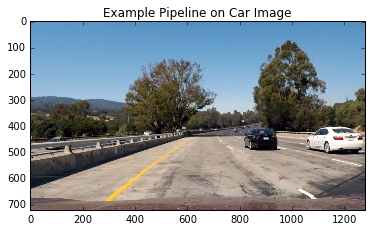

In [19]:

img = plt.imread("test_images/test1.jpg")

demo = process_image(img)

fig = plt.figure()
plt.subplot(111)
plt.imshow(demo)
plt.title('Example Pipeline on Car Image')


#### Video 

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#Uncomment one of the following 3
project_video = VideoFileClip('project_video.mp4')
project_video_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")

#challenge_video = VideoFileClip('challenge_video.mp4')
#challenge_video_output = 'challenge_video_output.mp4'
#clip = VideoFileClip("challenge_video.mp4")

#harder_challenge_video = VideoFileClip('harder_challenge_video.mp4')
#harder_challenge_video_output = 'harder_challenge_video_output.mp4'
#clip = VideoFileClip('harder_challenge_video.mp4')

#Uncomment one of the following 3
project_video_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)

#project_video_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
#%time project_video_clip.write_videofile(challenge_video_output, audio=False)

#project_video_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
#%time project_video_clip.write_videofile(harder_challenge_video_output, audio=False)

#.format(project_video_output))
#.format(challenge_video_output))
#.format(harder_challenge_video_output))

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [50:39<00:02,  2.32s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 49min 12s, sys: 1min 23s, total: 50min 36s
Wall time: 50min 40s


### Sources

* (1) http://scikit-image.org/docs/dev/auto_examples/plot_hog.html
* (2) https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md
* (3) http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
